1. generate synthetic 4D-STEM + GT mask

data4d: (128, 128, 128, 128) gt precip fraction: 0.08892822265625


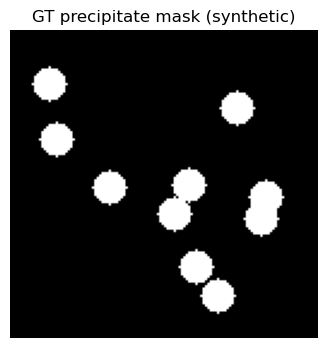

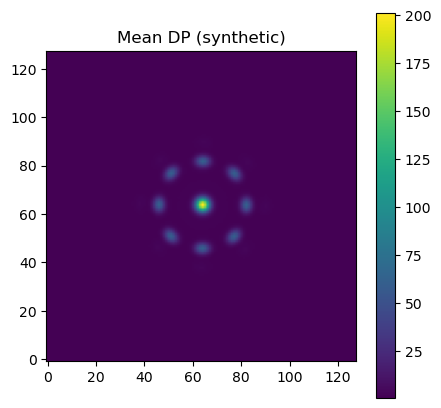

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def make_gaussian_peak(shape, cy, cx, sigma, amp=1.0):
    ky, kx = shape
    Y, X = np.ogrid[:ky, :kx]
    return amp * np.exp(-((Y-cy)**2 + (X-cx)**2)/(2*sigma**2)).astype(np.float32)

def rotate_points(points, angle_rad):
    R = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                  [np.sin(angle_rad),  np.cos(angle_rad)]])
    return points @ R.T

def synthetic_4dstem(ny=128, nx=128, ky=128, kx=128, seed=0,
                     n_precip=10, precip_radius=7,
                     base_spot_amp=80, precip_spot_amp=35,
                     noise_sigma=1.5):
    rng = np.random.default_rng(seed)
    data4d = np.zeros((ny,nx,ky,kx), dtype=np.float32)

    # GT precipitate mask: circles
    mask = np.zeros((ny,nx), dtype=bool)
    centers = rng.integers(low=15, high=min(ny,nx)-15, size=(n_precip, 2))
    Yg, Xg = np.ogrid[:ny, :nx]
    for (cy0, cx0) in centers:
        mask |= ((Yg-cy0)**2 + (Xg-cx0)**2 <= precip_radius**2)

    dcy, dcx = ky//2, kx//2

    base_pts = np.array([
        [0, 18], [0, -18], [18, 0], [-18, 0],
        [13, 13], [13, -13], [-13, 13], [-13, -13]
    ], dtype=np.float32)

    sat_pts = np.array([
        [0, 26], [0, -26], [26, 0], [-26, 0],
        [18, 18], [18, -18], [-18, 18], [-18, -18]
    ], dtype=np.float32)

    theta_max = np.deg2rad(10)
    yy = np.linspace(-1, 1, ny)[:, None]
    xx = np.linspace(-1, 1, nx)[None, :]
    angle_field = theta_max * (0.6*xx + 0.4*yy)
    thick_field = 0.85 + 0.3 * (xx + 1)/2

    # central beam
    central = make_gaussian_peak((ky,kx), dcy, dcx, sigma=2.0, amp=200)

    for i in range(ny):
        for j in range(nx):
            ang = angle_field[i, j]
            t = thick_field[0, j]

            dp = np.zeros((ky,kx), dtype=np.float32)
            dp += central

            pts = rotate_points(base_pts, ang)
            for py, px in pts:
                dp += make_gaussian_peak((ky,kx), dcy+py, dcx+px, sigma=1.6, amp=base_spot_amp)

            if mask[i, j]:
                pts2 = rotate_points(sat_pts, ang)
                for py, px in pts2:
                    dp += make_gaussian_peak((ky,kx), dcy+py, dcx+px, sigma=2.0, amp=precip_spot_amp)
                dp += make_gaussian_peak((ky,kx), dcy, dcx, sigma=14, amp=12)  # diffuse

            dp *= t
            dp += rng.normal(0, noise_sigma, size=(ky,kx)).astype(np.float32)
            dp = np.clip(dp, 0, None)
            data4d[i, j] = dp

    return data4d, mask

data4d_sim, mask_gt = synthetic_4dstem()
print("data4d:", data4d_sim.shape, "gt precip fraction:", mask_gt.mean())

plt.figure(figsize=(5,4))
plt.imshow(mask_gt, cmap="gray")
plt.title("GT precipitate mask (synthetic)")
plt.axis("off")
plt.show()

mean_dp = data4d_sim.mean(axis=(0,1))
plt.figure(figsize=(5,5))
plt.imshow(mean_dp, origin="lower")
plt.title("Mean DP (synthetic)")
plt.colorbar()
plt.show()

np.save("sim_data4d.npy", data4d_sim)
np.save("sim_mask_gt.npy", mask_gt.astype(np.uint8))

2. run same pipeline on synthetic + evaluate IoU/F1

Precipitate fraction per cluster: [0.0, 1.0] => precip_cluster: 1


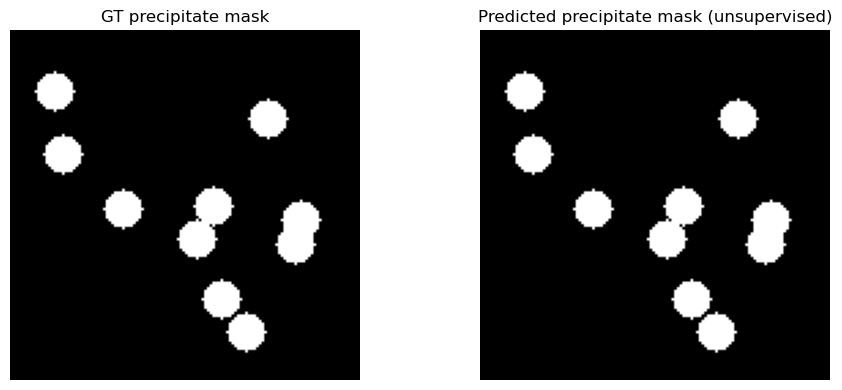

TP=1457 FP=0 FN=0 TN=14927
Precision=1.000 Recall=1.000 F1=1.000 IoU=1.000


In [5]:
from pipeline import run_pipeline
import numpy as np
import matplotlib.pyplot as plt

data4d_sim = np.load("sim_data4d.npy").astype(np.float32)
mask_gt = np.load("sim_mask_gt.npy").astype(bool)

out = run_pipeline(data4d_sim, nbins=20, method="kmeans", k=2, pca_use=5)

labels = out["labels"]

# Choose precipitate cluster automatically (higher GT fraction)
ygt = mask_gt.reshape(-1).astype(int)
lab = labels.reshape(-1)
fracs = [ygt[lab==c].mean() for c in np.unique(lab)]
precip_cluster = int(np.argmax(fracs))
ypred = (lab == precip_cluster).astype(int).reshape(labels.shape)

print("Precipitate fraction per cluster:", fracs, "=> precip_cluster:", precip_cluster)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(mask_gt, cmap="gray")
plt.title("GT precipitate mask")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ypred, cmap="gray")
plt.title("Predicted precipitate mask (unsupervised)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Metrics
ygt = mask_gt.reshape(-1).astype(int)
yp = ypred.reshape(-1).astype(int)

tp = np.sum((yp==1)&(ygt==1))
fp = np.sum((yp==1)&(ygt==0))
fn = np.sum((yp==0)&(ygt==1))
tn = np.sum((yp==0)&(ygt==0))

precision = tp/(tp+fp+1e-12)
recall = tp/(tp+fn+1e-12)
f1 = 2*precision*recall/(precision+recall+1e-12)
iou = tp/(tp+fp+fn+1e-12)

print(f"TP={tp} FP={fp} FN={fn} TN={tn}")
print(f"Precision={precision:.3f} Recall={recall:.3f} F1={f1:.3f} IoU={iou:.3f}")